<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/RNA_Interference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**What is RNA interference?** (simple intuition)

A short piece of RNA whose sequence is complementary to part of a messenger RNA can bind to that mRNA. When this happens, it “silences” the mRNA and prevents it from being
ranslated into a protein. The molecule that does the silencing is called a short interfering RNA (siRNA).

RNA interference is a complex biological mechanism. This serves both as a mechanism for regulating gene expression and as a defense against viruses.

**Importance**

It is a powerful tool for biology and medicine. It lets you temporarily “turn off ” any gene you want. You can use it to treat a disease, or to study what happens when a gene is disabled.

**Problem and tentative solution**

Some siRNA sequences work better than others, and if you want to use RNA interference as a tool, you need to know how to select a good one!

- Nature of problem: Regression.
- Model: 1-D Convolutional neural network
- Data: 2431 siRNA molecules, each 21 bases long ([related article](https://www.nature.com/articles/nbt1118)).
- Every molecule has been tested experimentally and labeled with a valued betweeen 0 and 1. How effective it is at silencing its target gene? Well, lower values are ineffective molecules, and values near to 1 indicate more effective ones. 

## Setup

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install --pre deepchem
import deepchem as dc
dc.__version__

## Dataset

In [2]:
# Create directories to load datasets (after run, please check 'folder' on the left side)
!mkdir 'rnai'
%cd 'rnai/'
!mkdir 'train_siRNA'
!mkdir 'valid_siRNA'

/content/rnai


**IMPORTANT TO DO**:

1.   [Download train_siRNA.](https://downgit.github.io/#/home?url=https://github.com/deepchem/DeepLearningLifeSciences/tree/master/Chapter06/train_siRNA)
2.   [Download valid_siRNA.](https://downgit.github.io/#/home?url=https://github.com/deepchem/DeepLearningLifeSciences/tree/master/Chapter06/valid_siRNA)
3. Upload files into rnai/ into corresponding dataset folder.
4. Wait until all files are loaded.

In [3]:
# Instance DiskDataset objects
train = dc.data.DiskDataset('train_siRNA')
valid = dc.data.DiskDataset('valid_siRNA')

## Model designing

In [4]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [7]:
input_shape = (21, 4) # vector of 21 bases, one-hot vector (4 bases)
batch_size = 1000

In [58]:
input = tf.keras.Input(shape=input_shape)
cnn = input

for _ in range(2):
  cnn = layers.Conv1D(filters=15, kernel_size=5, activation='relu', padding='same')(cnn)
  cnn = layers.Dropout(rate=0.3)(cnn) # regularization technique

cnn = layers.Flatten()(cnn)
output = layers.Dense(units=1, activation='relu')(cnn)
keras_model = tf.keras.Model(inputs=input, outputs=output)

loss = dc.models.losses.L2Loss() # it'll try to minimize the mean squared difference.

model = dc.models.KerasModel(
    model=keras_model,
    loss=loss,
    batch_size=batch_size,
    learning_rate=0.001
)

## Training

In [37]:
from tqdm.notebook import tqdm

**Pearson correlation coefficient (r)**: Measures the strength and direction of a linear relationship. For example, a perfectly linear relationship with a positive/negative trend has r=1/r=-1, while no linear relationship has r=0.

In [59]:
pearsonr = dc.metrics.Metric(dc.metrics.pearsonr, mode='regression')
epochs = 20

In [60]:
# Test performance in training and validation dataset
train_pearsonr = []
valid_pearsonr = []

for x in tqdm(range(20)):
  model.fit(dataset=train, nb_epoch=epochs)

  # print("Epoch {}/{}".format((x + 1) * epochs, 20 * epochs))

  train_score = model.evaluate(dataset=train, metrics=[pearsonr])
  # print('\nTRAINING correlation: ', train_score)
  valid_score = model.evaluate(dataset=valid, metrics=[pearsonr])
  #print('\nVALIDATION correlation: ', valid_score)

  train_pearsonr.append(train_score['pearsonr'])
  valid_pearsonr.append(valid_score['pearsonr'])

In [61]:
print('Final training correlation: {}'.format(train_pearsonr[-1]))
print('Final validation correlation: {}'.format(valid_pearsonr[-1]))

Final training correlation: 0.7290857327009186
Final validation correlation: 0.6214137099663454


## Testing

In [62]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

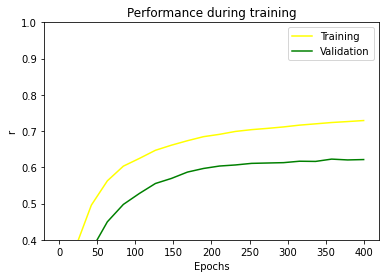

In [63]:
x = np.linspace(0, epochs * 20, 20)

plt.title('Performance during training')
plt.plot(x, train_pearsonr, label='Training', color='yellow')
plt.plot(x, valid_pearsonr, label='Validation', color='green')

plt.xlabel('Epochs')
plt.ylabel('r')

plt.ylim(0.40, 1.0)

plt.legend()
plt.show()